In [1]:
import tensorflow as tf
import sys, imageio, os
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
sys.path.append("/Users/kai/Downloads/graduation/final_git/MasterThesis/src/")
from config import *

In [2]:
tf.config.run_functions_eagerly(True)

## Data import

In [3]:
path = os.path.join(dataset_path,"single_focus_-0.3_train")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")
im = imageio.imread(im_path)
with open(label_path, "rb") as f:
    label = np.load(f)
label = np.expand_dims(label,1)
np.random.seed(0)
n_label = np.random.permutation(label.shape[0])
print('Data Type: %s' % im.dtype)
print('Min: %.3f, Max: %.3f' % (im.min(), im.max()))

Data Type: uint8
Min: 117.000, Max: 198.000


/var/folders/74/hchwhhz568x878t9vflxnjfh0000gn/T/ipykernel_18868/833259439.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(im_path)


In [4]:
im.shape

(107, 120)

## Model

In [5]:
def model1():
    """
    This is the first model structure for the CNN.
    """
    input = keras.layers.InputLayer(input_shape=(120,1)) # image shape is 120 dimension
    scaling = keras.layers.Rescaling(1 / 255)
    # https://stats.stackexchange.com/questions/383310/what-is-the-difference-between-kernel-bias-and-activity-regulizers-and-when-t
    # Kernel Regularizer: Tries to reduce the weights 𝑊 (excluding bias).
    # Bias Regularizer: Tries to reduce the bias 𝑏.
    # Activity Regularizer: Tries to reduce the layer's output 𝑦, thus will reduce the weights and adjust bias so 𝑊𝑥+𝑏 is smallest.
    # TODO: try different Regularizer,L1 ,L2
    Conv1 = keras.layers.Conv1D(
        filters = 300, kernel_size=12,
        strides = 3,   activation="relu",
        name    ="conv1", activity_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))
    pool1 = keras.layers.MaxPooling1D(2)
    Conv2 = keras.layers.Conv1D(
        filters = 320, kernel_size=8,
        strides =3,     activation="relu",
        name="conv2",  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
    pool2 = keras.layers.MaxPooling1D(2)
    flatten = keras.layers.Flatten()
    Dense1 = keras.layers.Dense(units = 340,activation="relu",name="dense1",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
    Dense2 = keras.layers.Dense(units = 220,activation="relu",name="dense2",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
    # Problem                                       last-later activation               loss function
    # Binary classification                         sigmoid                             binary crossentropy
    # Multiclass, single-label classification       softmax                             categorical crossentropy
    # Multiclass, multilabel classification         sigmoid                             binary crossentropy
    # Regression to arbitrary values                None                                mse
    # Regression to values between 0 and 1          sigmoid                             mse or binary crossentropy
    output = keras.layers.Dense(units = 1,activation=None,name="output",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
    model = keras.models.Sequential([input,scaling,Conv1,pool1,Conv2,pool2,flatten,Dense1,Dense2,output])
    return model

In [6]:
# TODO: try different optimizer, learning rate.
model = model1()
model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
            metrics=[tf.keras.metrics.mean_absolute_error],)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 37, 300)           3900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 300)          0         
 )                                                               
                                                                 
 conv2 (Conv1D)              (None, 4, 320)            768320    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 320)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0

## Evaluation

In [7]:
def evaluate_model(model,n_label,n_split:int,shuffle=True,random_state=42):
    from sklearn.model_selection import StratifiedKFold,KFold
    # before evaluate the KFold or StratifiedKFold, check the distrabution
    # check the percentage normally Train60;Validation20;Test20
    evaluations = []
    historys = []
    skf = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
    # https://www.projectpro.io/recipes/explain-stratified-k-fold-cross-validation
    # https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b 
    # Notice stratified need cannot use for continued data. Need to group it
    kf = KFold(n_splits=n_split,shuffle=shuffle,random_state=random_state)
    for train, test in kf.split(n_label):
        train_feature = im[train]
        train_label   = label[train]
        test_feature  = im[test]
        test_label    = label[test]

        model = model1()
        #TODO: try different optimizer, learning rate,batch_size,epochs
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
            metrics=[tf.keras.metrics.mean_absolute_error],)
        history = model.fit(
                        x=train_feature,
                        y=train_label,
                        epochs=60,
                        batch_size=5,
                        verbose=1,
                        validation_data=(test_feature, test_label)
                    )
        evaluate = model.evaluate(test_feature, test_label)
        evaluations.append(evaluate)
        historys.append(history)
    return model,historys,evaluations


In [8]:
model, history, evaluations = evaluate_model(model,n_label,n_split=3,shuffle=True,random_state=42)

Epoch 1/60
 4/15 [=======>......................] - ETA: 0s - loss: 23.6135 - mean_absolute_error: 4.3564

/Users/kai/miniconda3/envs/project/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-04-03 20:58:43.990162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 0s 26ms/step - loss: 28.8583 - mean_absolute_error: 4.8615 - val_loss: 22.8242 - val_mean_absolute_error: 4.3127
Epoch 2/60
15/15 [==============================] - 0s 25ms/step - loss: 18.0860 - mean_absolute_error: 3.6660 - val_loss: 8.0355 - val_mean_absolute_error: 2.0015
Epoch 3/60
15/15 [==============================] - 0s 25ms/step - loss: 7.4887 - mean_absolute_error: 1.9235 - val_loss: 5.6810 - val_mean_absolute_error: 1.9043
Epoch 4/60
15/15 [==============================] - 0s 25ms/step - loss: 6.3735 - mean_absolute_error: 1.7136 - val_loss: 5.3070 - val_mean_absolute_error: 1.5414
Epoch 5/60
15/15 [==============================] - 0s 25ms/step - loss: 6.0986 - mean_absolute_error: 1.6576 - val_loss: 5.0508 - val_mean_absolute_error: 1.6760
Epoch 6/60
15/15 [==============================] - 0s 25ms/step - loss: 6.3161 - mean_absolute_error: 1.7957 - val_loss: 5.2009 - val_mean_absolute_error: 1.7538
Epoch 7/60
15/15 [============

In [9]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

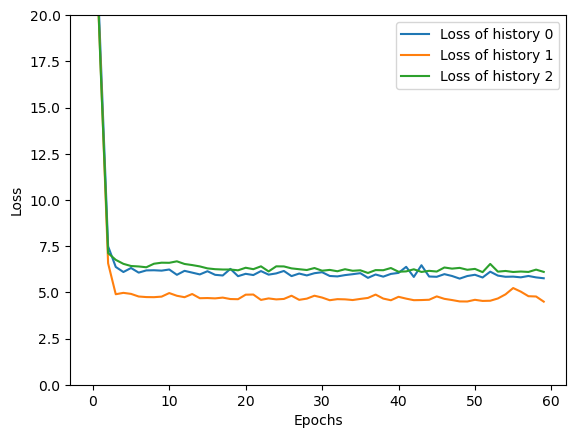

In [10]:
import matplotlib.pyplot as plt
for i in range(len(history)):
    plt.plot(history[i].history["loss"],label="Loss of history {}".format(i))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.ylim(0, 20)
plt.show()

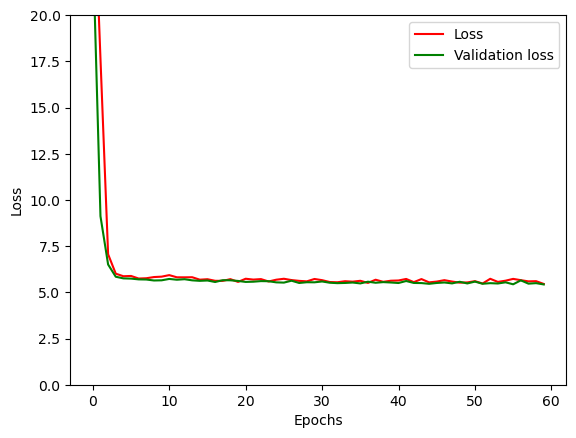

In [11]:
import matplotlib.pyplot as plt
val_loss = np.mean([history[i].history["val_loss"] for i in range(len(history))],axis=0)
loss = np.mean([history[i].history["loss"] for i in range(len(history))],axis=0)

plt.plot(loss, 'r-', label='Loss')
plt.plot(val_loss, 'g-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 20)
plt.legend()
plt.show()

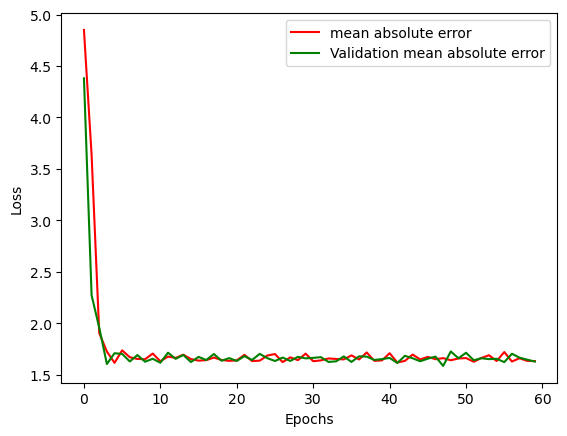

In [12]:
import matplotlib.pyplot as plt
val_loss = np.mean([history[i].history["val_mean_absolute_error"] for i in range(len(history))],axis=0)
loss = np.mean([history[i].history["mean_absolute_error"] for i in range(len(history))],axis=0)

plt.plot(loss, 'r-', label='mean absolute error')
plt.plot(val_loss, 'g-', label='Validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Retrain the best model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(im,label,test_size=0.4, random_state=42,shuffle=True)

In [14]:
model = model1()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error],
)
                        
history = model.fit(X_train,y_train, batch_size=5, epochs=10,verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
 2/13 [===>..........................] - ETA: 0s - loss: 35.8922 - mean_absolute_error: 5.3494

/Users/kai/miniconda3/envs/project/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


13/13 [==============================] - 1s 40ms/step - loss: 27.9746 - mean_absolute_error: 4.8324 - val_loss: 28.5783 - val_mean_absolute_error: 4.7968
Epoch 2/10
13/13 [==============================] - 0s 27ms/step - loss: 20.5767 - mean_absolute_error: 4.0972 - val_loss: 17.5885 - val_mean_absolute_error: 3.5606
Epoch 3/10
13/13 [==============================] - 0s 27ms/step - loss: 8.9001 - mean_absolute_error: 2.3754 - val_loss: 6.6236 - val_mean_absolute_error: 1.8177
Epoch 4/10
13/13 [==============================] - 0s 29ms/step - loss: 6.1532 - mean_absolute_error: 1.8228 - val_loss: 6.5364 - val_mean_absolute_error: 1.9239
Epoch 5/10
13/13 [==============================] - 0s 29ms/step - loss: 5.3064 - mean_absolute_error: 1.4995 - val_loss: 6.9603 - val_mean_absolute_error: 1.8018
Epoch 6/10
13/13 [==============================] - 0s 33ms/step - loss: 5.2857 - mean_absolute_error: 1.5068 - val_loss: 6.6107 - val_mean_absolute_error: 1.8133
Epoch 7/10
13/13 [===========

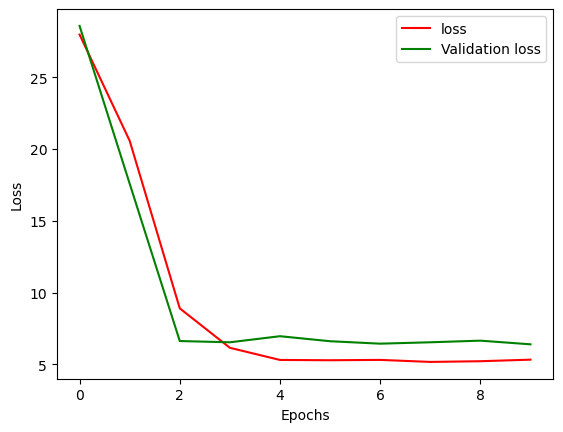

In [15]:
plt.plot(history.history["loss"], 'r-', label='loss')
plt.plot(history.history["val_loss"], 'g-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 9ms/step - loss: 6.3955 - mean_absolute_error: 1.8620


[6.3954949378967285, 1.8619980812072754]

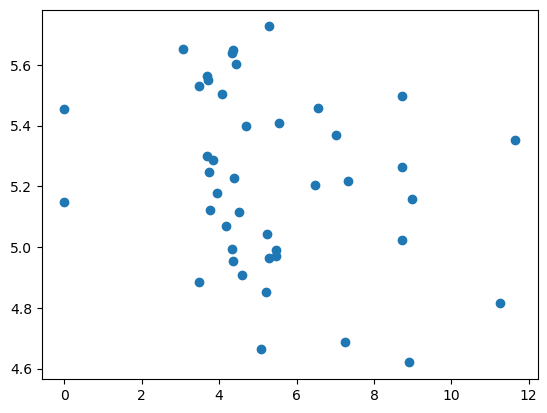

In [19]:
plt.plot(y_test,model.predict(X_test),"o")
plt.show()

In [28]:
# The model is not good so far.
# TODO: try data augmentation, add more layers, change image size, increase epochs
# First priority hyper-tuning
save_path = os.path.join(os.path.split(storage_path)[0], "models", "model_test_CNN")
model.save(save_path)

INFO:tensorflow:Assets written to: /Users/kai/Downloads/graduation/code/models/model_test_CNN/assets
2022-10-28 13:30:31,751-[INFO]- tensorflow:779 -> Assets written to: /Users/kai/Downloads/graduation/code/models/model_test_CNN/assets


## Hyper-tuning

https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html